# Bell inequality

_This notebook is an integral part of the paper [Bell inequalities wih Qibo](), where the popular inequalities concerning quantum Bell states are presented for educational purposes._

In the second of this series, we instantiate a quantum circuit with Qibo to study the violation of the inequality originally introduced by Bell in 1964. Let's define the quantity $Q^B$ as:

$$Q^B = |\overline{\alpha\beta} -\overline{\alpha\gamma}| - \overline{\beta\gamma}$$

where $\overline{\alpha\beta}$ represents the average of the product of the two measurements of $a$ and $b$, that is their _correlation_ (cf. paper). In the assumption of local hidden (LH) variables, the inequality reads:

$$Q^B_{LH} \leq 1$$

We will show that in a Qibo quantum circuit the inequality is violated in the case of entangled particles.

In the [third notebook](https://cernbox.cern.ch/s/XrulbU127OSUkNF) (temporary link), we turn to the popular CHSH inequality.


## Setup

Let's start by importing the necessary Python packages. You can install Qibo by executing `pip install qibo` in your environment, see [Qibo Quick start](https://qibo.science/qibo/stable/getting-started/quickstart.html) for further details.

In [1]:
import time
from math import pi
import qibo
from qibo import Circuit, gates
import matplotlib.pyplot as plt

qibo.set_backend(backend="numpy")

[Qibo 0.2.11|INFO|2024-10-07 14:07:08]: Using numpy backend on /CPU:0


In [2]:
WIDTH = 0.5
FONTSIZE = 12

# parameters for the simulation
ab_steps = 4
phi_steps = 4
ac_steps = 50
nshots = 50000

Here we instantiate a circuit with free parameters $\phi$ and $\theta$ for the rotations before the measurement. The initial $R_Y$ gates stay with a $\theta = \pi$ rotation in order to convert a $|0\rangle$ initial state to $|1\rangle$ prior to constructing the Bell state.

In [3]:
c = Circuit(2)
c.add(gates.RY(q=0, theta=pi))
c.add(gates.RY(q=1, theta=pi))
c.add(gates.H(0))
c.add(gates.CNOT(q0=0, q1=1))
c.add(gates.RZ(q=0, theta=0))
c.add(gates.RZ(q=1, theta=0))
c.add(gates.RY(q=0, theta=0))
c.add(gates.RY(q=1, theta=0))
c.add(gates.M(0, 1))
print('%s\n' % c.draw())

q0: ─RY─H─o─RZ─RY─M─
q1: ─RY───X─RZ─RY─M─



Now we define a function to run the simulation for some given values of $\phi_0$, $\phi_1$, $\theta_0$, and $\theta_1$. In this case, the returned value is the _correlation_ $C(q_0, q_1) = \overline{q_0 q_1}$, which is required to compute the $Q^B$ quantity.

We also define a number of parameters for the simulation.

In [4]:
def run_circuit_C(phi_0, phi_1, th_0, th_1):
    '''run the simulation for the given choice of phi_0, phi_1, theta_0, theta_1,
       and return the correlation between the two qbits'''
    c.set_parameters([pi, pi, phi_0, phi_1, th_0, th_1])
    freqs = c(nshots=nshots).frequencies()
    # return the cross correlation: +1 when q0 = q1, -1 otherwise, averaged over all shots
    return (freqs['00'] + freqs['11'] - freqs['01'] - freqs['10']) / nshots

Now run the simulation, and note the computation time on different hardware backends.

In [5]:
Q_B = {}
tstart = time.time()
for i_ab in range(ab_steps+1):
    print('Run for theta_ab = %2dpi/%d...' % (i_ab, ab_steps))

    th_ab = pi * i_ab/ab_steps    # theta_ab angles go from 0 to pi inclusive
    C_ab = run_circuit_C(0, 0, 0, th_ab)

    Q_B[i_ab] = []

    for i_ac in range(ac_steps+1):
        th_ac = pi * i_ac/ac_steps    # theta_ac angles go from 0 to pi inclusive
        C_ac = run_circuit_C(0, 0, 0, th_ac)
        C_cb = run_circuit_C(0, 0, th_ac, th_ab)
        Q_B[i_ab].append(abs(C_ab - C_ac) - C_cb)

print('Completed in %.1f seconds' % (time.time() - tstart))

Run for theta_ab =  0pi/4...
Run for theta_ab =  1pi/4...
Run for theta_ab =  2pi/4...
Run for theta_ab =  3pi/4...
Run for theta_ab =  4pi/4...
Completed in 1.4 seconds


## Plots

Here we plot the obtained values of $Q^B$ using multiple parametric lines and common `matplotlib` primitives.

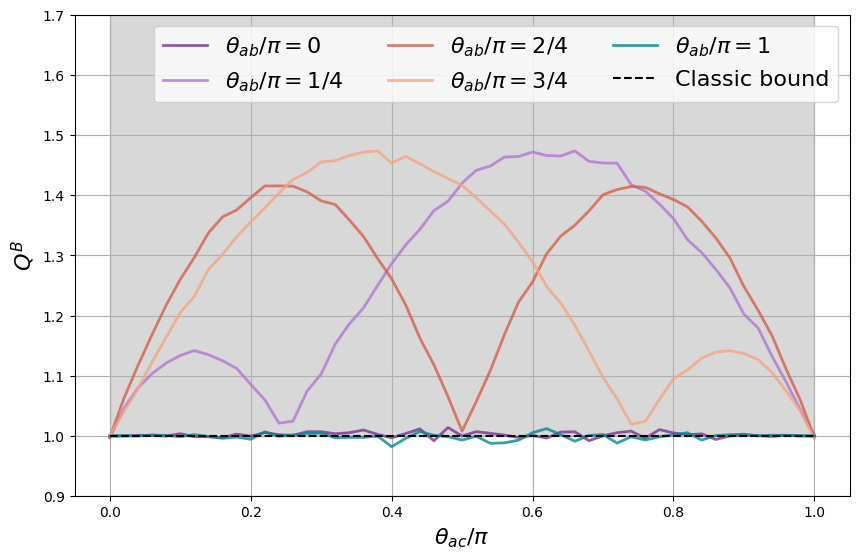

In [6]:
from qiboedu.scripts.plotscripts import plot_bell_inequalities

plot_bell_inequalities(Q_values=Q_B, ac_steps=ac_steps, ab_steps=ab_steps, img_width=1, y_bounds=(0.9, 1.7), savetitle="bw_1")

As an additional exercise, we generate a radial plot: this plot better illustrates the evolution of $Q^B$ when changing $\theta_{ac}$ from 0, which corresponds to $\hat{c}$ aligned with the $z$ axis, conventionally represented as the North direction, to $\pi$, which corresponds to $\hat{c}$ pointing to the South direction.

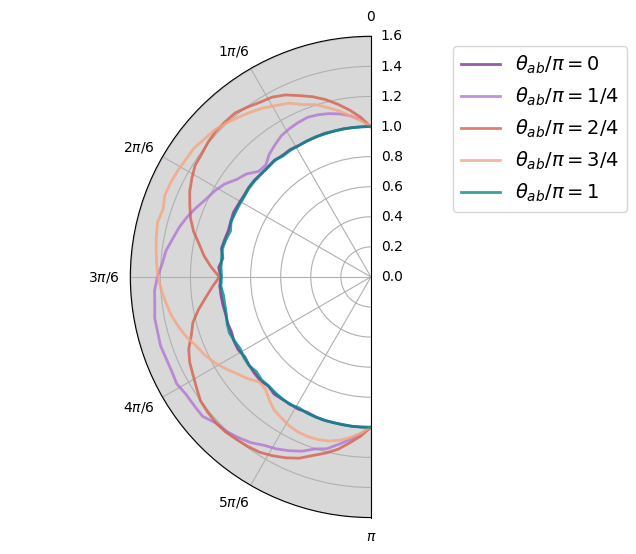

In [7]:
plot_bell_inequalities(Q_values=Q_B, ac_steps=ac_steps, ab_steps=ab_steps, img_width=1, plot_projection="polar", savetitle="bw_2")

## Rotation around the _z_ axis

This is an alternate simulation, where for the $c$ measurement we rotate around the $z$ axis by the angle $\phi$ and then around the $y$ axis by the angle $\theta_{ac}$, while we keep $\theta_{ab}$ constant.

The simulation runs over different values of $\phi$ and $\theta_{ac}$.

In [8]:
Q_B = {}
tstart = time.time()

th_ab = pi/2
C_ab = run_circuit_C(0, 0, 0, th_ab)
for i_phi in range(phi_steps+1):
    print('Run for phi = %dpi/%d...' % (i_phi, phi_steps))

    phi = pi * i_phi/phi_steps    # phi angles go from 0 to pi inclusive
    Q_B[i_phi] = []

    for i_ac in range(ac_steps+1):
        th_ac = pi * i_ac/ac_steps    # theta_ac angles go from 0 to pi inclusive
        C_ac = run_circuit_C(0, phi, 0, th_ac)
        C_cb = run_circuit_C(phi, 0, th_ac, th_ab)
        Q_B[i_phi].append(abs(C_ab - C_ac) - C_cb)

print('Completed in %.1f seconds' % (time.time() - tstart))

Run for phi = 0pi/4...
Run for phi = 1pi/4...
Run for phi = 2pi/4...
Run for phi = 3pi/4...
Run for phi = 4pi/4...
Completed in 1.5 seconds


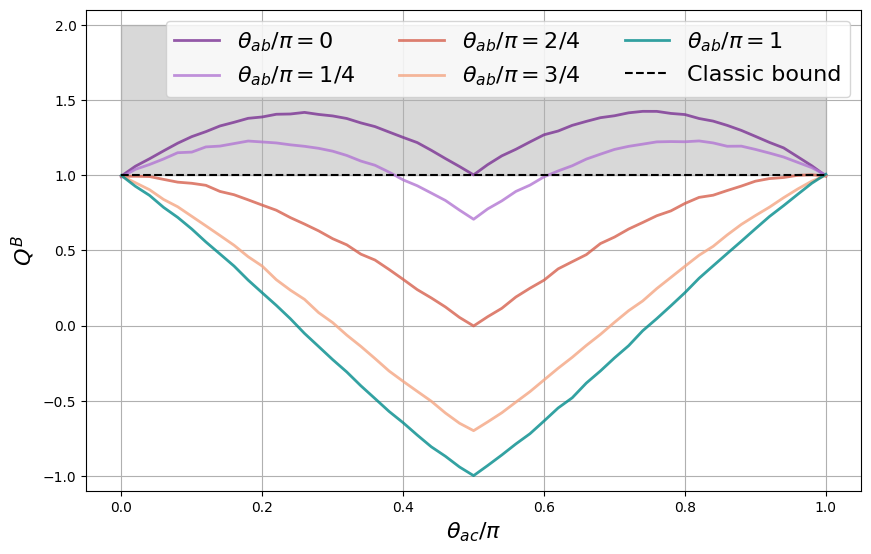

In [9]:
plot_bell_inequalities(Q_values=Q_B, ac_steps=ac_steps, ab_steps=ab_steps, img_width=1, savetitle="bw_3", y_bounds=(-1.1, 2.1))